In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21
A = np.zeros((Nnodes,Nnodes),dtype = int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k,k+4] = 1
for k in range(4,7):  
    A[k,k+5] = 1
for k in range(9,12):  
    A[k,k+5] = 1
for k in range(14,17):  
    A[k,k+4] = 1
# horizontal springs
for k in range(3,7):
    A[k,k+1] = 1
for k in range(8,12):  
    A[k,k+1] = 1
for k in range(13,17):  
    A[k,k+1] = 1
# symmetrize
Asymm = A + np.transpose(A)
# indices of nodes on the hoop
ind_hoop = [0,3,8,13,18,19,20,17,12,7,2,1]
Nhoop = np.size(ind_hoop)
# indices of free nodes (not attached to the hoop)
ind_free = [4,5,6,9,10,11,14,15,16]
Nfree = np.size(ind_free)
# list of springs
springs = np.array(np.nonzero(A))

Nsprings = np.size(springs,axis=1)
print(springs.shape)


(2, 24)


In [3]:
# Initialization

# Initial angles for the nodes are uniformly distributed around the range of 2*pi
# startting from theta0 and going counterclockwise
theta0 = 2*np.pi/3
theta = theta0 + np.linspace(0,2*np.pi,Nhoop+1)
theta = np.delete(theta,-1)
# Initial positions
pos = np.zeros((Nnodes,2))
pos[ind_hoop,0] = Rhoop*np.cos(theta)
pos[ind_hoop,1] = Rhoop*np.sin(theta)
pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 

# Initiallize the vector of parameters to be optimized
vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))

In [4]:
def initialize():
    # Initialization

    # Initial angles for the nodes are uniformly distributed around the range of 2*pi
    # startting from theta0 and going counterclockwise
    theta0 = 2*np.pi/3
    theta = theta0 + np.linspace(0,2*np.pi,Nhoop+1)
    theta = np.delete(theta,-1)
    # Initial positions
    pos = np.zeros((Nnodes,2))
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
    pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 
    
    # Initiallize the vector of parameters to be optimized
    vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))
    return vec

In [5]:
def draw_spring_system(pos,springs,R,ind_hoop,ind_free):
    # draw the hoop
    t = np.linspace(0,2*np.pi,200)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(R*np.cos(t),R*np.sin(t),linewidth = 5,color = 'red')
    # plot springs
    Nsprings = np.size(springs,axis=1)
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        plt.plot([pos[j0,0],pos[j1,0]],[pos[j0,1],pos[j1,1]],color = 'black',linewidth = 3)    
    # plot nodes
    plt.scatter(pos[ind_hoop,0],pos[ind_hoop,1],s = 300,color = 'crimson')
    plt.scatter(pos[ind_free,0],pos[ind_free,1],s = 300,color = 'black')

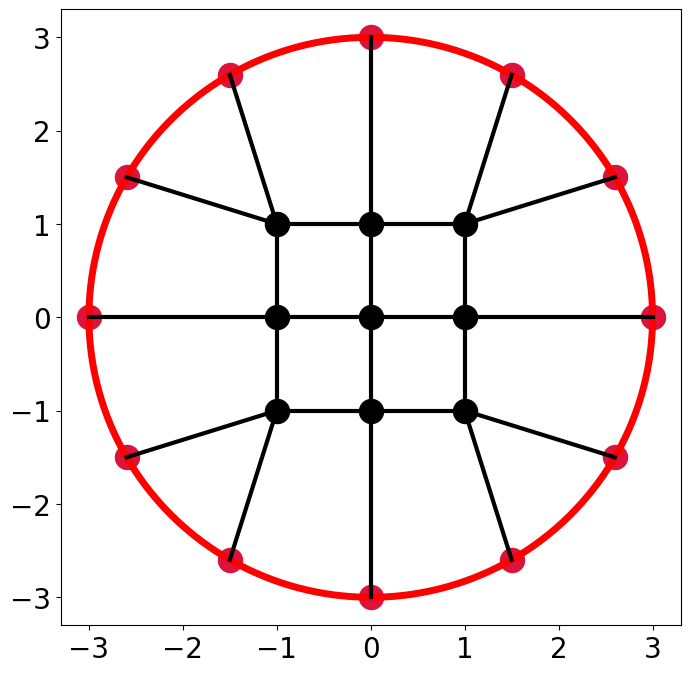

In [6]:
# Draw the initial configuration of the spring system
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)

In [7]:
def compute_gradient(theta,pos,Asymm,r0,kappa,R,ind_hoop,ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree,2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k],:])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k],:] - pos[ind,:] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        # print(k,ind,ind_hoop[k],rvec)
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k],:]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k],:] - pos[ind[j],:] # the vector from the jth adjacent node to the kth free node 
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k,:] = g_free[k,:] + (rvec_length - r0)*R*kappa*rvec/rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop,g_free[:,0],g_free[:,1]))     

def Energy(theta,pos,springs,r0,kappa):
    Nsprings = np.size(springs,axis = 1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        rvec = pos[j0,:] - pos[j1,:]
        rvec_length = np.linalg.norm(rvec)        
        E = E + kappa*(rvec_length - r0)**2
    E = E*0.5
    return E
    

In [8]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    # positions of the free nodes
    pos[ind_free,0] = vec[Nhoop:Nnodes]
    pos[ind_free,1] = vec[Nnodes:] 
    return theta,pos

def gradient(vec):
    theta,pos = vec_to_pos(vec) 
    return compute_gradient(theta,pos,Asymm,r0,kappa,Rhoop,ind_hoop,ind_free)

def func(vec):
    theta,pos = vec_to_pos(vec) 
    return Energy(theta,pos,springs,r0,kappa)


In [9]:
#START HERE: The optimizer-- includes both methods in one function
def optimize(vec, method):
    #initializations 
    iter_max=1000
    tol=1e-6
    alpha=0.1
    f=func(vec)
    g=gradient(vec)
    norm_g=np.linalg.norm(g)
    
    fvals=np.zeros(iter_max)
    gvals= np.zeros(iter_max)
    fvals[0] = f
    gvals[0] = norm_g
    
    itr=0
    c = 0.1
    rho = 0.9
    
    B=np.eye(len(vec))
    vec_old=np.zeros(len(vec))
    g_old=np.zeros(len(g))
    
    #begin iteration
    while norm_g>tol and itr<iter_max:
        if( method == 'GD'): # steepest descent
            p = -g
            # dir = "SD"
        elif( method == 'BFGS'): #BFGS
        
            s=vec-vec_old
            y=g-g_old
            B=B-(np.outer(B.dot(s),B.dot(s)))/(s.dot(B).dot(s) + 1e-12)+(np.outer(y,y))/(y.dot(s) +1e-12)
            
            spd = np.all(np.linalg.eigvals(B) > 0)
            if( spd ): # H is SPD, use BFGS direction
                p = np.linalg.solve(B,-g) 
            else: # use the steepest descent direction
                print("Hessian is not SPD, using steepest descent direction\n")
                p = -g
                
            norm_p=np.linalg.norm(p)
            if( norm_p > 1):
                p = p/norm_p
            # do backtracking line search along the direction p
            a = 1 # initial step length
            f_temp = func(vec + a*p)
            cpg = c*np.dot(p,g)
        #     print("cpg = ",cpg,"f = ",f,"f_temp = ",f_temp)
            while( f_temp > f + a*cpg ): # check Wolfe's condition 1
                a = a*rho
                if( a < 1e-14 ):
                    print("line search failed\n")
                    itr = iter_max - 1
                    break
                f_temp = func(vec + a*p)  
        
        #both methods- updating vec, energy, gradient 
        vec_old=vec
        g_old=g
        
        vec=vec+alpha*p
        f=func(vec)
        g=gradient(vec)
        norm_g=np.linalg.norm(g)
        
        itr += 1
        fvals[itr] = f
        gvals[itr] = norm_g
        # print(f"iter {itr}: f = {f},  norm_g = {norm_g:.6e},") #{f:.6f}
        
    print(f"iter {itr}:\nf = {f:.6f}\nnorm_g = {norm_g:.6e}\ntheta = {theta}\npos = {pos}")
    return vec,fvals[0:itr],gvals[0:itr] 
    


In [10]:
#function for plotting the energy and gradient norm
def plot_all(y_axis, y_label, title):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 16})
    plt.title(title)
    plt.plot(y_axis)
    plt.xlabel("Iteration #")
    plt.ylabel(y_label)
    plt.yscale("log")
    plt.show()

iter 150:
f = 1.492451
norm_g = 9.965719e-07
theta = [2.0943951  2.61799388 3.14159265 3.66519143 4.1887902  4.71238898
 5.23598776 5.75958653 6.28318531 6.80678408 7.33038286 7.85398163]
pos = [[-2.12131945e+00  2.12132124e+00]
 [ 9.18485099e-16  3.00000000e+00]
 [ 2.12131945e+00  2.12132124e+00]
 [-2.12132124e+00  2.12131945e+00]
 [-1.28644040e+00  1.28644040e+00]
 [ 3.46434406e-16  1.46011554e+00]
 [ 1.28644040e+00  1.28644040e+00]
 [ 2.12132124e+00  2.12131945e+00]
 [-3.00000000e+00  3.67394040e-16]
 [-1.46011554e+00  3.21562632e-16]
 [-1.31810352e-17  3.33066907e-17]
 [ 1.46011554e+00 -2.65649435e-16]
 [ 3.00000000e+00 -7.34788079e-16]
 [-2.12132124e+00 -2.12131945e+00]
 [-1.28644040e+00 -1.28644040e+00]
 [-2.96287610e-16 -1.46011554e+00]
 [ 1.28644040e+00 -1.28644040e+00]
 [ 2.12132124e+00 -2.12131945e+00]
 [-2.12131945e+00 -2.12132124e+00]
 [-5.51091060e-16 -3.00000000e+00]
 [ 2.12131945e+00 -2.12132124e+00]]


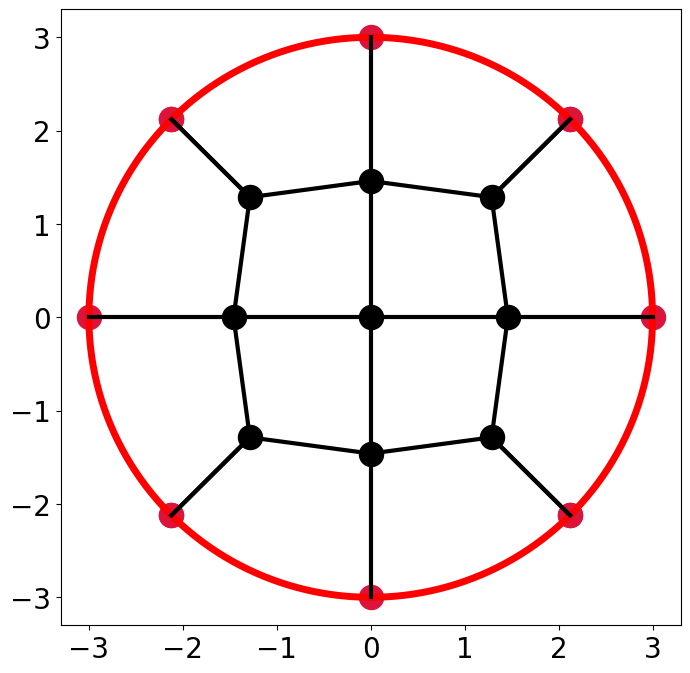

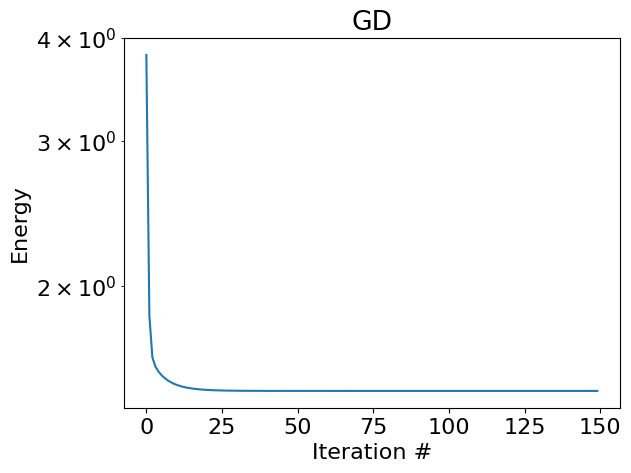

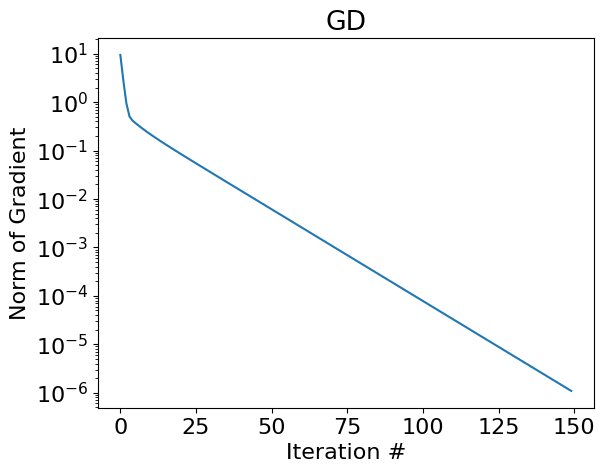

Hessian is not SPD, using steepest descent direction

iter 153:
f = 1.492451
norm_g = 9.868777e-07
theta = [2.35619407 2.35619491 3.14159265 3.9269904  3.92699124 4.71238898
 5.49778672 5.49778757 6.28318531 7.06858305 7.06858389 7.85398163]
pos = [[-1.53014016e+00  2.58044009e+00]
 [ 7.42674112e-01  2.90661920e+00]
 [ 2.58044010e+00  1.53014016e+00]
 [-1.53014041e+00  2.58043995e+00]
 [-9.27928843e-01  1.56486605e+00]
 [ 3.61463264e-01  1.41466659e+00]
 [ 1.56486605e+00  9.27928809e-01]
 [ 2.58044025e+00  1.53013990e+00]
 [-2.90661921e+00  7.42674075e-01]
 [-1.41466661e+00  3.61463295e-01]
 [-2.64114847e-08 -6.33629727e-09]
 [ 1.41466656e+00 -3.61463319e-01]
 [ 2.90661917e+00 -7.42674215e-01]
 [-2.58044021e+00 -1.53013996e+00]
 [-1.56486608e+00 -9.27928782e-01]
 [-3.61463345e-01 -1.41466659e+00]
 [ 9.27928757e-01 -1.56486610e+00]
 [ 1.53014011e+00 -2.58044012e+00]
 [-2.58044005e+00 -1.53014023e+00]
 [-7.42674224e-01 -2.90661917e+00]
 [ 1.53013986e+00 -2.58044027e+00]]


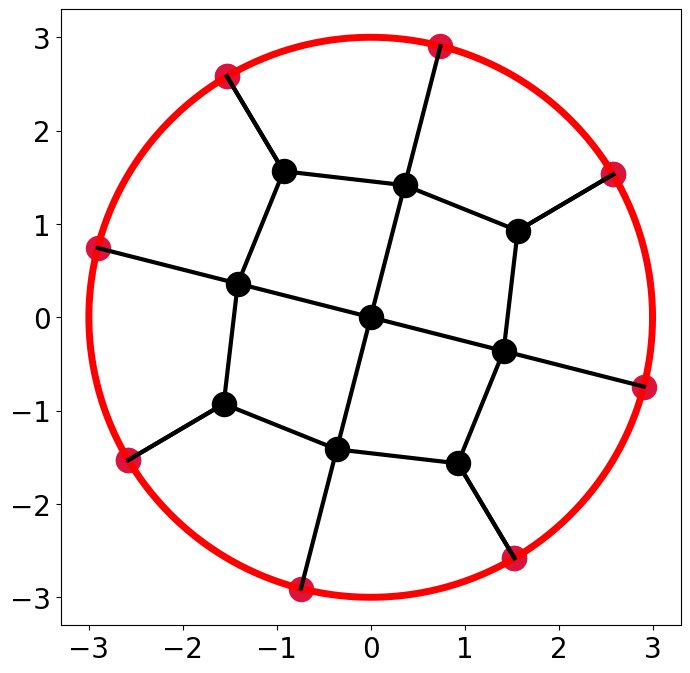

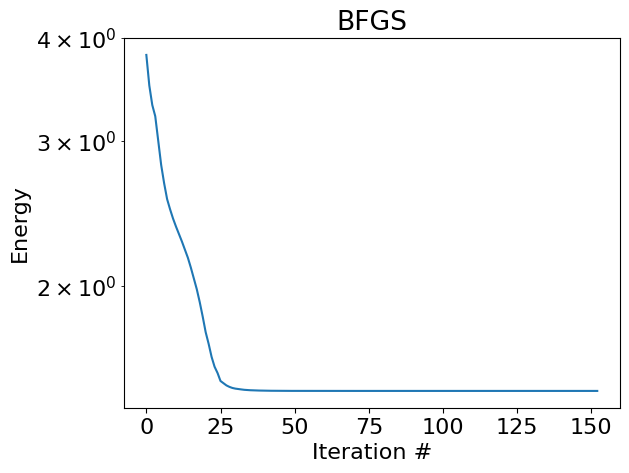

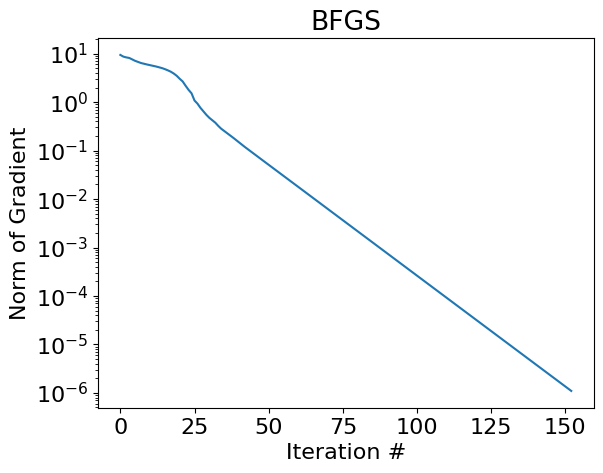

In [11]:
'''
1. initialize nodes to original positions
2. run the optimizer
3. draw the spring system
4. plot the energy and gradient norm
'''

for method in ['GD','BFGS']: 
    vec = initialize()
    vec,fvals, gvals=optimize(vec, method)
    theta,pos=vec_to_pos(vec)
    draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free) 
    plot_all(fvals, "Energy", method)
    plot_all(gvals, "Norm of Gradient", method)
